## A Manipulate Function Equivalent for SymPy

In this notebook I define a `plots` function that enables plotting of multiple expressions with different colors, and a `manipulate` function that enables varying input parameters in a plot using ipython widget sliders.

In [1]:
%matplotlib inline

from sympy import *
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, FloatSlider

sns.set_style('white')
init_printing()

## plots

The function `plots` attempts to fix a problem with the standard SymPy `plot` function $-$ when multiple expressions are plotted at once, they are plotted with the same color. Here, I have imported seaborn and used the default color scheme that they provide, but other color schemes may be inserted.

In [2]:
def plots(plots, x_range, labels=None, colors=None, show=True, **kwargs):
    """
    extends functionality of plot to enable easy plotting of multiple functions with different colors
    corresponding to the standard or a custom color scheme
    """
    palette = sns.color_palette()
    
    if labels is None:
        labels = []
    if colors is None:
        colors = []
    
    # group a list of sympy plot objects in a list, and then group them
    # together into a single plot object.
    plot_list = []
    for i in range(len(plots)):
        if i >= len(labels):
            label = ('plot %d' % i)
        else:
            label = label[i]
                   
        if i >= len(colors):
            color = palette[i % len(palette)]
        else:
            color = colors[i % len(colors)]
                   
        plot_list.append(plot(plots[i], x_range, line_color=color, 
                              label=label, show=False, **kwargs))
    
    p = plot_list[0]
    for i in range(1,len(plot_list)):
        p.extend(plot_list[i])
    
    if show:
        p.show()
    
    return p

Here is an example of the `plots` function in use to plot multiple plots at once:

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


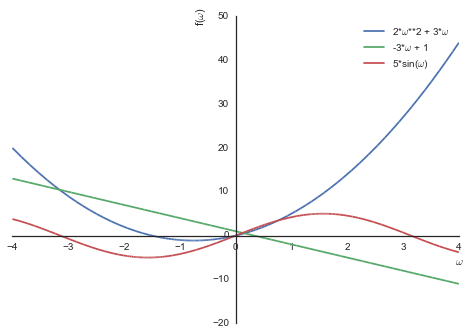

In [3]:
w, q, t = symbols('$\\omega$ $\\theta$ t')

expr1 = 2*w**2 + 3*w
expr2 = -3*w + 1
expr3 = 5*sin(w)

p = plots((expr1,expr2,expr3),(w,-4,4), legend = True)

It would be nice if the legend could be placed outside of the plot (so as not to interfere with the plot) and would also render latex expressions.

## manipulate

Here is the manipulate function. It provides similar functionality to the `Manipulate[]` function in Mathematica in that it provides the capacity to vary input parameters in a plot using slider widgets. It is based on ipython widgets interacting with the `plots` function defined above.

In [4]:
def manipulate(exprs, x_range, vary=None, **more_kwargs):
    """
    This function is similar to but extends the 'plots' functions from
    above (which itself extends the sympy 'plot' function), and is intended
    to produce similar behavior to the Mathematica 'Manipulate' function
    whereby, an expression can be plotted and previously undefined parameters
    in the expressions can be varied using slider widgets.
    
    Here, this is achieved by taking advantage of the ipython 'FloatSlider' widget
    and the ipython 'interact' function.
    
    ::inputs::
    exprs:     a sympy expression for plotting or tuple or list of sympy expressions
               for plotting.
    x_range:   a tuple or list of the form (*sympy symbol*,*float min*,*float max*) that
               designates the variable to plot with respect to and the range to plot over.
    vary:      a tuple of the form (*sympy symbol*,*float min*,*float max*[,*float step*]) or of 
               the form ((*sympy symbol*,*float value*),*float min*,*float max*[,*float step*]) 
               or a list of such tuple forms.
    **more_kwargs: keyword arguments used that are passed to the plotting function.
    """
    
    varz    = {}
    sliders = {}
    
    #perform some checks and fixes on variable types:
    if not(isinstance(exprs,tuple) or isinstance(exprs,list)):
        exprs = (exprs,)
        
    if vary is None:
        params = []
    elif isinstance(vary, list):
        params = vary
    elif isinstance(vary, tuple):
        params = [vary]
    else:
        IOError("""vary must be a tuple of the form (*symbol*,*min*,*max*[,*step*])
                   or of the form ((*symbol*,*value*),*min*,*max*[,*step*]) or a list
                   of such tuple forms """)
    
    # create a dictionaries of the sympy symbols that are to be manipulated
    # and a dictionary of the associated slider objects.
    for p in params:
        if isinstance(p[0],tuple):
            var = p[0][0]
            value= p[0][1]
        else:
            var = p[0]
            value= p[1]
            
        if len(p) == 4:
            step = p[3]
        elif len(p) == 3:
            step = (p[2] - p[1])/20
        else:
            raise IOError("""incorrect length for manipulated parameter,
                             should be 3 or 4""")
            
        varz[var.name]    = var
        sliders[var.name] = FloatSlider(description=var.name, 
                                       min=p[1], max=p[2],
                                       value=value, step=step)
        
    # create a function that performs the plotting that is updated
    # when the sliders move:
    def cplot(**kwargs):
        """
        this is a dummy plotting function that is called by the function
        'interact' in order to update the plots when the sliders change value.
        """
        
        conditions = []
        for k,v in kwargs.items():
            conditions.append((varz[k], v))
            
        p_exprs = []
        for e in exprs:
            p_exprs.append(e.subs(conditions))
        p_exprs = tuple(p_exprs)
            
        p = plots(p_exprs, x_range, **more_kwargs)
        return p
            
    # create the interaction between the plot and the sliders.
    i = interact(cplot,**sliders)
    
    # return the interact object and the plot object
    # (for no reason, yet, but there might be a reason to do so)
    return i, p

Here is an example of the manipuate function in use:

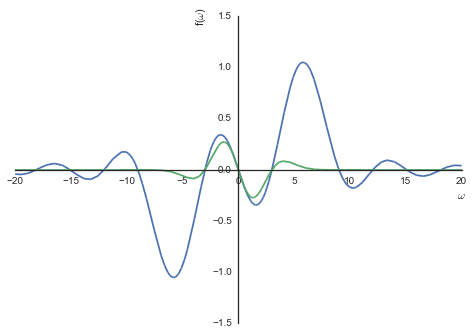

In [6]:
expr4 = sin((2*q - w)*t)/(2*q - w) - sin((2*q + w)*t)/(2*q + w)
expr5 = exp(-w**2/((q)**2))*expr4

_ = manipulate((expr4, expr5), (w,-20,+20), 
               vary=[((t, 1), 0, 2.5, .05), ((q, 3), 0, 5, .1)], 
               legend=False)